# ANU - TP4 - Approximation spectrale

B. Boutin, Y. Le Hénaff et M. Bouchereau

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## I - Méthode de la puissance

Cette première partie propose d'implémenter la méthode de la puissance, d'abord afin de visualiser le taux de convergence sur une petite matrice de taille 2 x 2, et ensuite de l'implémenter sur une matrice de taille quelconque.

### 1 - Observation du taux de convergence

On s'intéresse à la matrice 2 x 2 suivante:

$$A = \begin{bmatrix}
        1 & 2 \\
        2 & 1
       \end{bmatrix}$$
       
**Q1 -** Déterminer la plus grande valeur propre de $A$ (en module) et la seconde plus grande (donc la plus petite en module ici). Implémenter la méthode de la puissance et observer le taux de convergence sur cette matrice.

lambda_1: [[3.]]  - Remarque: La seconde valeur propre de A a pour valeur -1
v_1 =  [[0.70710677]
 [0.70710679]]


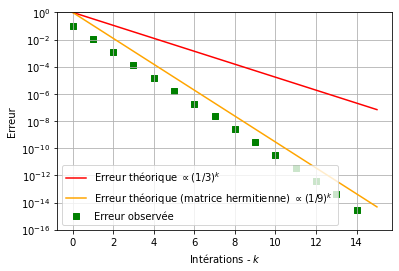

In [2]:
def Puissance(A , Max_iter = 100 , tol = 1e-8):
    """
    Applique la methode de la puissance à la matrice `A`, supposée carrée.
    Entrée:
    - A: Array de taille (d,d), où d est un entier naturel non nul.
    - Max_iter: Int - Nombre maximal d'itérations. Defaut: 100
    - tol: Float - Tolérence pour la convergence. Defaut: 1e-8
    """
    d = A.shape[0] # taille de la matrice (supposee carre!)

    b_k = np.random.rand(d, 1) # pre-allocation du vecteur bk, pour ne pas avoir une allocation a chaque iteration de la boucle while
    
    cur_iter = 0 # compte le nombre d'iterations passees
    
    Lambda, lambda_k, old_lambda_k = [], 0., 0.
    
    diff_lambda = 2*tol + 1 # n'importe quelle valeur plus grande que tol, pour rentrer dans la boucle while:
    
    while (cur_iter < Max_iter) and (diff_lambda > tol):
        old_lambda_k = lambda_k
        b_k = A @ b_k # @ est la multiplication matricielle
        
        # normalisation 'in-place' du vecteur pour qu'il soit unitaire :
        b_k /= np.linalg.norm(b_k) 

        # estimation de la valeur propre :
        lambda_k = b_k.conj().T @ A @ b_k 
        # Pour calculer le transconjugue d'un vecteur, on prend son conjuge (`.conj()`) puis on le transpose (`.T`)
        
        diff_lambda = np.abs(lambda_k - old_lambda_k) # on regarde la difference entre les estimation courante et ancienne des valeurs propres
        
        # Ajout de lambda_k à la liste Lambda pour étudier la convergence
        Lambda.append(lambda_k[0,0])
        
        cur_iter += 1
    
    if diff_lambda > tol:
        # Si la méthode n'a pas convergé après `max_iter` itérations, on retourne une erreur :
        raise TimeoutError(f"La méthode de la puissance n'a pas convergé après {max_iter} itérations, l'erreur finale est {diff_lbd}. Essayez un nombre d'itérations plus grand.")
    else:
        return Lambda, lambda_k, b_k
    

A = np.array([[1,2],[2,1]])
Lambda, lambda_1, v_1 = Puissance(A, Max_iter=100, tol=1e-14)
print("lambda_1:",lambda_1 , f" - Remarque: La seconde valeur propre de A a pour valeur {-1}")
print("v_1 = ", v_1)

K = np.array(list(range(len(Lambda))))
Err = np.array([np.abs(lambda_k-lambda_1[0,0]) for lambda_k in Lambda]) # Erreur de convergence
Err_th = np.array([(1/3)**k for k in K]) # Erreur théorique
Err_th_h = np.array([(1/9)**k for k in K]) # Erreur théorique (matrices hermitiennes)


plt.figure()
plt.scatter(K , Err , color = "green" , marker = "s" , label = "Erreur observée")
plt.plot(K , Err_th , color = "red" , label = "Erreur théorique $\propto (1/3)^k$")
plt.plot(K , Err_th_h , color = "orange" , label = "Erreur théorique (matrice hermitienne) $\propto (1/9)^k$")
plt.yscale("log")
plt.ylim(1e-16,1)
plt.legend()
plt.grid()
plt.xlabel("Intérations - $k$")
plt.ylabel("Erreur")
plt.show()
    
    


### 2 - Méthode de la puissance pour une matrice symétrique de taille quelconque

Pour une matrice symétrique réelle $A$ de taille $d \times d$ admettant pour valeurs propres $\lambda_1,\cdots,\lambda_d$ telles que $|\lambda_1|>\cdots>|\lambda_d|$, on peut adapter la méthode de la puissance afin d'en extraire toutes les valeurs et vecteurs propres (NB: La base de vecteurs propres est orthogonale et les valeurs propres sont toutes réelles). Pour cela, on suit les étapes suivantes:

- On détermine d'abord la plus grande valeur propre (en module) $\lambda_1$ ainsi qu'un vecteur propre $v_1$.
- On applique la méthode de la puissance à la matrice $\tilde{A}_1 = A - \lambda_1v_1v_1^*$, cette matrice admet pour valeurs propres $0,\lambda_2,\cdots,\lambda_d$, donc on va extraire $\lambda_2$ et $v_2$ comme vecteur propre associé.
- On applique de nouveau la méthode de la puissance à la matrice $\tilde{A}_2 = A - \lambda_1v_1v_1^* - \lambda_2v_2v_2^*$ pour extraire $\lambda_3$ et $v_3$.
- $\vdots$
- On applique la méthode de la puissance à la matrice $\tilde{A}_k = A - (\lambda_1v_1v_1^* + \cdots + \lambda_kv_kv_k^*)$ pour extraire $\lambda_{k+1}$ et $v_{k+1}$.

**Q2 -** Coder la méthode de la puissance et la tester sur une matrice symétrique quelconque (par exemple de taille 10 x 10), comparer avec la fonction $\verb|np.linalg.eigh|$

In [3]:
def Puissance_deflation(A, nb_vp, Max_iter=1000, tol=1e-8):
    """
    Utilise la méthode de la déflation avec la méthode de la puissance pour récupérer les `nb_vp` premiers vecteurs propres.
    Elle s'applique à des matrices *symétriques*.
    Entrées:
    - A: Array de taille (d,d), où d est un entier naturel non nul. Il doit être SYMETRIQUE
    - nb_vp: Int - Nombre de valeus/vecteurs propres que l'on veut extraire.
    - Max_iter: Int - Nombre maximal d'itérations. Defaut: 100
    - tol: Float - Tolérence pour la convergence. Defaut: 1e-8
    """
    # on verifie que la matrice est Hermitienne :
    if not np.allclose(A.conj().T, A):
        raise ValueError("La matrice n'est pas Hermitienne.")
    
    d = A.shape[0] # taille de la matrice, supposee carree
    
    if nb_vp > d:
        print("Le nombre de vecteurs propres demandé est trop grand, on va donc chercher tous les vecteurs propres de la matrice.")
        nb_vp = d
    

    V = np.empty((d, nb_vp)) # on va stocker les vecteurs propres dans cette matrice, avec V[:, i-1] le i-eme vecteur propre
    Lambda = np.empty(nb_vp) # on va stocker les valeurs propres dans ce vecteur, avec Lambda[:, i-1] la i-eme valeur propre
    for j in range(min(nb_vp, d)):
        # technique de la deflation :
        tildeA = A.copy()
        for jj in range(j):
            matVjj = V[:, jj].reshape((-1, 1)) # On met le jj-eme vecteur propre enregistré aux bonnes dimensions.
            # `(-1, 1)` indique qu'on veut que toutes les composantes soient dans la première colonne.
            # Pourquoi on fait ça ? `V[:, jj]` retourne un vecteur numpy de taille `d`, i.e. à une seule dimension.
            # Pour pouvoir faire le calcul matriciel correctement, il faut que ce soit une matrice de taille `d x 1`.
            tildeA -= Lambda[jj] * matVjj @ matVjj.conj().T
        
        try:
            # On applique la methode de la puissance à la matrice `tildeA` :
            lambdas, l, v = Puissance(tildeA, Max_iter=Max_iter, tol=tol)

            # S'il n'y a pas eu d'erreurs, on enregistre le vecteur propre obtenu et la valeur propre correspondante :
            V[:, j] = v.reshape(-1).copy()
            Lambda[j] = l
        except TimeoutError as te:
            # S'il y a eu une erreur durant la `power_iteration`, on retourne une erreur :
            raise ValueError("Il n'y a pas eu convergence durant la recherche d'un des vecteurs propres.\n" +
                            f"Durant la recherche du {j}-ème vecteur propre : \n\t{te}")


    return Lambda, V

# Test sur la matrice du Laplacien discret
d = 5
A = 2*np.diag(np.ones(d),0) - np.diag(np.ones(d-1),1) - np.diag(np.ones(d-1),-1)

#A = np.random.uniform(size=(d,d))
#A += A.conj().T

print("Test avec la méthode de la puissance et déflation:")
lambdas , V = Puissance_deflation(A ,nb_vp = d , Max_iter = 100 , tol = 1e-14)
print(lambdas)
print(V)

print(" ")
print("Test avec la librairie np.linalg.eigh:")
lambdas_bis , V_bis = np.linalg.eigh(A)
print(lambdas_bis)
print(V_bis)

Test avec la méthode de la puissance et déflation:
[3.73205081 3.         2.         1.         0.26794919]
[[-2.88675057e-01 -5.00000018e-01  5.77350345e-01  4.99999947e-01
   2.88675082e-01]
 [ 4.99999922e-01  5.00000097e-01 -2.29837108e-08  5.00000014e-01
   4.99999948e-01]
 [-5.77350269e-01 -1.49906275e-07 -5.77350269e-01  7.75638250e-08
   5.77350269e-01]
 [ 5.00000078e-01 -4.99999903e-01  2.29836917e-08 -4.99999986e-01
   5.00000052e-01]
 [-2.88675212e-01  4.99999982e-01  5.77350193e-01 -5.00000053e-01
   2.88675187e-01]]
 
Test avec la librairie np.linalg.eigh:
[0.26794919 1.         2.         3.         3.73205081]
[[-2.88675135e-01  5.00000000e-01 -5.77350269e-01 -5.00000000e-01
  -2.88675135e-01]
 [-5.00000000e-01  5.00000000e-01  9.91449050e-17  5.00000000e-01
   5.00000000e-01]
 [-5.77350269e-01 -2.26646689e-16  5.77350269e-01  1.59862670e-16
  -5.77350269e-01]
 [-5.00000000e-01 -5.00000000e-01 -2.33868629e-16 -5.00000000e-01
   5.00000000e-01]
 [-2.88675135e-01 -5.0000000

## II - Méthode QR

Dans cette seconde partie, on s'intéresse à l'application de la méthode QR pour la recherche de valeurs propres. Il est également possible (cf. théormème 80 du cours, Chapitre 3), de trouver les vecteurs propres. Pour cela, on suit les étapes suivantes:

- On fait la décomposition QR de $A$: $A = Q_0R_0$. On pose $V_0 = Q_0$ et $A_1 = R_0Q_0$.
- On fait la décomposition QR de $A_1$: $A_1 = Q_1R_1$. On pose $V_1 = V_0Q_1$ et $A_2 = R_1Q_1$.
- $\vdots$
- On fait la décomposition QR de $A_k$: $A_{k} = Q_{k}R_{k}$. On pose $V_{k} = V_{k-1}Q_{k}$ et $A_{k+1} = R_kQ_k$.
- On continue avec un nombre assez grand d'itérations.

La diagonale de $(A_k)_{k\in\mathbb{N}}$ converge vers la diagonale des valeurs propres de $A$, la suite $(V_k)_{k\in\mathbb{N}}$ converge vers la liste des vecteurs propres associés $[v_1|\cdots|v_d]$.

**Q3 -** Coder la méthode QR avec recherche de vecteurs propres et la tester sur une matrice symétrique quelconque (par exemple de taille 5 x 5). Pour la décomposition QR, on utilisera la fonction $\verb|np.linalg.qr|$, et pour la vérification, on comparera soit vec la méthode de la puissance, soit la fonction $\verb|np.linalg.eigh|$.

In [4]:
def QR_VP(A , Max_iter = 100):
    """Méthode QR donnant le spectre d'une matrice ainsi que les vecteurs propres.
    Entrées:
    - A: Array de taille (d,d) - Matrice étudiée
    - Max_iter: Int - Nombre maximal d'itérations. Defaut: 100"""
    
    B = A
    d = A.shape[0]
    V = np.eye(d,d)
    for j in range(100):
        Q,R = np.linalg.qr(B)
        B = R@Q # Matrice dont la diagonale va converger vers les valeurs propres de A
        V = V@Q # Matrice dont les colonnes forment une base de vecteurs propres associés
    
    return np.diag(B) , V

    
# Test sur la matrice du Laplacien discret

d = 5
A = 2*np.diag(np.ones(d),0) - np.diag(np.ones(d-1),1) - np.diag(np.ones(d-1),-1)

#A = np.random.uniform(size=(d,d))
#A += A.conj().T

print("Test avec la méthode QR:")
lambdas , V = QR_VP(A , Max_iter = 10)
print(lambdas)
print(V)

print(" ")
print("Test avec la librairie np.linalg.eigh:")
lambdas_bis , V_bis = np.linalg.eigh(A)
print(lambdas_bis)
print(V_bis)

Test avec la méthode QR:
[3.73205081 3.         2.         1.         0.26794919]
[[ 2.88675135e-01  5.00000000e-01  5.77350269e-01  5.00000000e-01
   2.88675135e-01]
 [-5.00000000e-01 -5.00000000e-01 -1.87056357e-17  5.00000000e-01
   5.00000000e-01]
 [ 5.77350269e-01 -3.29132029e-10 -5.77350269e-01  6.20492449e-19
   5.77350269e-01]
 [-5.00000000e-01  5.00000000e-01  6.89839233e-17 -5.00000000e-01
   5.00000000e-01]
 [ 2.88675134e-01 -5.00000000e-01  5.77350269e-01 -5.00000000e-01
   2.88675135e-01]]
 
Test avec la librairie np.linalg.eigh:
[0.26794919 1.         2.         3.         3.73205081]
[[-2.88675135e-01  5.00000000e-01 -5.77350269e-01 -5.00000000e-01
  -2.88675135e-01]
 [-5.00000000e-01  5.00000000e-01  9.91449050e-17  5.00000000e-01
   5.00000000e-01]
 [-5.77350269e-01 -2.26646689e-16  5.77350269e-01  1.59862670e-16
  -5.77350269e-01]
 [-5.00000000e-01 -5.00000000e-01 -2.33868629e-16 -5.00000000e-01
   5.00000000e-01]
 [-2.88675135e-01 -5.00000000e-01 -5.77350269e-01  5.0

## III - Application: Tenseur de déformation

En mécanique, le tenseur de déformation d'un matériau va représenter la manière dont une contrainte sur ce matériau va le déformer, dans le plan ou dans l'espace. Il est représenté par une matrice de taille 2 x 2 (déformation dans le plan) ou 3 x 3 (déformation dans l'espace). Dans notre application, nous nous concentrerons sur le cas de la dimension 2.

Ainsi, une déformation va avoir des directions principales et, selon ces directions principales, va correspondre à une dilatation. ces directions principales sont données par les vecteurs propres du tenseur, les coefficients de dilatation correspondant aux valeurs propres du tenseur.

Ainsi, un tenseur de déformation en dimension 2 appliqué aux points d'un cercle va donner une ellipse, dont l'orientation est donnée par les vecteurs propres de la matrice 2 x 2, et les rayons par les modules des valeurs propres de la matrice.


$$T_1 = \begin{bmatrix}
        1 & 2 \\
        2 & 1
      \end{bmatrix} , T_2 = \begin{bmatrix}
        1 & 2 \\
        2 & 5
      \end{bmatrix} , T_3 = \begin{bmatrix}
        1 & 2 \\
        2 & 0
      \end{bmatrix}$$
      
**Q4 -** En testant les exemples suivants, appliquer la matrice aux points d'un cercle, afficher le cercle, l'ellipse obtenue, les vecteurs propres sur un même graphique. Calculer les valeurs et vecteurs propres des matrices données en exemple. On utilisera au choix la méthode de la puissance (question Q2) ou la méthode QR (question Q3).

Tenseur T_1:
[[1 2]
 [2 1]]
Valeurs propres:  3.0  -  -0.9999999999999997
Vecteurs propres associés:  [0.70710678 0.70710678]  -  [-0.70710678  0.70710678]


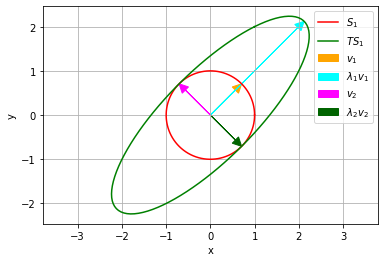

Tenseur T_2:
[[1 2]
 [2 5]]
Valeurs propres:  5.828427124746187  -  0.17157287525381001
Vecteurs propres associés:  [0.38268343 0.92387953]  -  [-0.92387953  0.38268343]


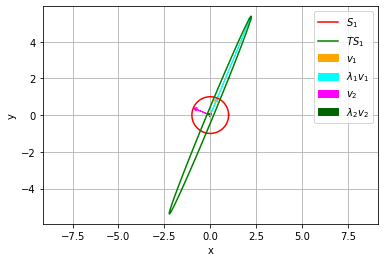

Tenseur T_3:
[[1 2]
 [2 0]]
Valeurs propres:  2.561552812808833  -  -1.5615528128088298
Vecteurs propres associés:  [0.78820544 0.61541221]  -  [-0.61541221  0.78820544]


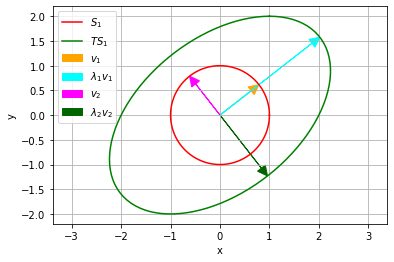

In [5]:
def Deformation(T):
    """Affiche la déformation d'un cercle en ellipse selon une matrice T.
    Entrée:
    - T: Array de taille (2,2) - Tenseur de déformation, symétrique"""
    
    # Calcul de valeurs et vecteurs propres
    
    lambdas , P = QR_VP(T)
    
    print("Valeurs propres: ",lambdas[0]," - ",lambdas[1])
    print("Vecteurs propres associés: ", P[:,0] , " - " , P[:,1])
    
    # Affichage du tenseur de déformations
    
    theta = np.linspace(0,2*np.pi,100)
    U = np.zeros((2,np.size(theta)))
    U[0,:] , U[1,:] = np.cos(theta) , np.sin(theta)

    V = T@U

    plt.figure()
    plt.plot(U[0,:],U[1,:],color="red",label="$S_1$")
    plt.plot(V[0,:],V[1,:],color="green",label="$T S_1$")
    plt.arrow(0,0,P[0,0],P[1,0], head_length=0.2 , head_width=0.2 , length_includes_head = True , color = "orange" , edgecolor = None , label = "$v_1$")
    plt.arrow(0,0,lambdas[0]*P[0,0],lambdas[0]*P[1,0], head_length=0.2 , head_width=0.2 , length_includes_head = True , color = "cyan" , edgecolor = None , label = "$\lambda_1v_1$")
    plt.arrow(0,0,P[0,1],P[1,1], head_length=0.2 , head_width=0.2 , length_includes_head = True , color = "magenta" , edgecolor = None , label = "$v_2$")
    plt.arrow(0,0,lambdas[1]*P[0,1],lambdas[1]*P[1,1], head_length=0.2 , head_width=0.2 , length_includes_head = True , color = "darkgreen" , edgecolor = None , label = "$\lambda_2v_2$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.axis("equal")
    plt.show()
    
    pass

T1 = np.array([[1,2],[2,1]])
T2 = np.array([[1,2],[2,5]])
T3 = np.array([[1,2],[2,0]])

print("Tenseur T_1:")
print(T1)
Deformation(T1)

print("Tenseur T_2:")
print(T2)
Deformation(T2)

print("Tenseur T_3:")
print(T3)
Deformation(T3)